In [1]:
import os
import sys
sys.path.append('../')

from IPython.core.pylabtools import figsize

#from utils import get_intervals
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform, compute_p_vals

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from sklearn.metrics import confusion_matrix

In [3]:
def log_transform(x, scale_factor=10000):
    norm_x = np.log(scale_factor * x/x.sum(0))
    return(norm_x)

# x numpy vector of counts
# transformation to apply to the non-zero elements of x.
def process_counts(x, transformation):
    cell_count = len(x)
    N_0 = np.sum(x == 0)
    N_plus = cell_count - N_0
    t_x = transformation(x[np.where(x > 0)])    
    return(t_x, N_plus, N_0)

# return p-value -- we are using Normal assumption on the means for inference. The null is that the means are the same.
def infer_lfc(m_x, s_x, m_y, s_y):
    diff = m_x - m_y 
    s_hat = np.sqrt((s_x**2) + (s_y**2))
    lb = diff - 1.96*s_hat
    ub = diff + 1.96*s_hat
    # Compute the p-value.
    z_score = diff / s_hat
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return(lb,ub,p_value)


In [4]:
# Read in the counts data
data_folder = "../simul/splatter/"
X = pd.read_csv(os.path.join(data_folder, "X.csv")).to_numpy()
Y = pd.read_csv(os.path.join(data_folder, "Y.csv")).to_numpy()
#cell_counts_X = X.sum(axis=1)
#cell_counts_Y = Y.sum(axis=1)
n_genes = Y.shape[0]
n_cells = Y.shape[1]
print("n_genes: ", n_genes)
print("n_cells: ", n_cells)
print("shape X:", X.shape)
print("shape Y:", Y.shape)

lfcs = pd.read_csv(os.path.join(data_folder, "fc.csv"))
lfcs2 = pd.read_csv(os.path.join(data_folder, "fc2.csv"))
#idx = np.argsort(lfcs)

# Y_A = Y[:,X.loc[X["trt"] == "A"].index]
# Y_B = Y[:,X.loc[X["trt"] == "B"].index]
# print(Y_A.shape)
# print(Y_B.shape)


n_genes:  4043
n_cells:  973
shape X: (4043, 1027)
shape Y: (4043, 973)


In [5]:
X = X.transpose()
Y = Y.transpose()

print("shape Y:", Y.shape)

shape Y: (973, 4043)


In [6]:
ziln_lfcs, p_vals = get_ZILN_lfcs(np.exp(transform(Y)) - 1, np.exp(transform(X)) - 1, eps=1e-3, return_p_vals=True)

In [7]:
adj_pvals = smm.multipletests(p_vals, alpha=0.05, method='fdr_bh')[1]
adj_pvals

array([9.57019231e-01, 9.19293933e-01, 9.69477687e-01, ...,
       9.97745599e-01, 9.85932493e-01, 1.17541922e-06])

In [8]:
pred_sig_idx = (adj_pvals < 0.05)

In [9]:
gt_sig_idx = (lfcs["true_log2_fc"] != 0)

In [10]:
conf_mat = confusion_matrix(gt_sig_idx, pred_sig_idx)
conf_mat

array([[3234,   26],
       [ 327,  456]])

In [11]:
tn, fp, fn, tp = conf_mat.ravel()

In [22]:
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print results
print(f"TPR: {tpr:.2f}")
print(f"TNR: {tnr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"FNR: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

TPR: 0.58
TNR: 0.99
FPR: 0.01
FNR: 0.42
Precision: 0.95
Recall: 0.58


In [13]:
gt_lfcs = lfcs["true_log2_fc"]
print("Ground Truth:")
print("#LFCs: ", gt_sig_idx.sum())
print("#Non-LFCs: ", (1 - gt_sig_idx).sum())

print("ZILN:")
print("#LFCs: ", pred_sig_idx.sum())
print("#Non-LFCs: ", (1 - pred_sig_idx).sum())

Ground Truth:
#LFCs:  783
#Non-LFCs:  3260
ZILN:
#LFCs:  482
#Non-LFCs:  3561


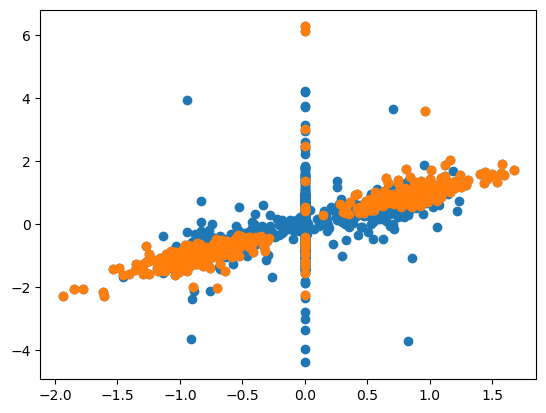

In [14]:
plt.scatter(gt_lfcs, ziln_lfcs)
plt.scatter(gt_lfcs[pred_sig_idx], ziln_lfcs[pred_sig_idx])

[  17   20   24   27   29   31   38   42   48   68   77   78   89   98
  106  125  164  169  171  183  185  191  220  229  239  241  252  256
  269  276  288  297  299  318  346  376  409  411  426  431  451  452
  485  488  490  498  513  531  552  555  567  587  598  605  618  619
  624  628  629  630  638  650  666  686  700  707  740  768  771  784
  819  821  847  852  858  871  884  899  910  929  946  956  959  982
  983 1007 1016 1039 1040 1041 1042 1050 1054 1064 1079 1083 1115 1119
 1126 1142 1147 1161 1170 1177 1183 1214 1215 1224 1241 1243 1261 1268
 1300 1309 1320 1330 1353 1359 1364 1372 1405 1417 1458 1498 1500 1535
 1541 1550 1552 1557 1562 1572 1589 1591 1603 1617 1618 1622 1637 1644
 1646 1672 1685 1722 1724 1755 1762 1764 1791 1795 1796 1805 1815 1841
 1872 1884 1889 1890 1901 1903 1949 1959 1962 2000 2009 2013 2014 2044
 2046 2058 2060 2071 2073 2085 2119 2176 2184 2192 2196 2208 2212 2217
 2251 2256 2258 2276 2341 2361 2386 2391 2401 2408 2410 2418 2431 2433
 2437 

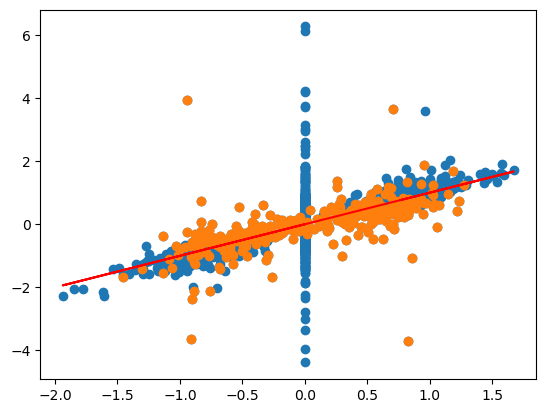

In [15]:
# indices of all false negatives
FN_idx = ((gt_sig_idx.astype(int) - pred_sig_idx.astype(int)) > 0).astype(bool)
print(np.arange(len(FN_idx))[FN_idx])

print("#FNs: ", FN_idx.sum())
# print(np.sum(X[:, FN_idx], 0))
# print(np.sum(Y[:, FN_idx], 0))
plt.scatter(gt_lfcs, ziln_lfcs)
plt.scatter(gt_lfcs[FN_idx], ziln_lfcs[FN_idx])
plt.plot(gt_lfcs, gt_lfcs, color='red')
plt.show()


In [16]:
# seurat_lfcs = get_seurat_lfcs(Y.transpose(), X.transpose(), normalize=True)
seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(Y, X, normalize=True)
#seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)

In [17]:
ii = (ziln_lfcs == np.inf) | (ziln_lfcs == -np.inf)
jj = np.isnan(lfcs2["avg_log2FC"])
print(np.where(ii))
kk = ii | jj

(array([], dtype=int64),)


In [18]:
np.mean((ziln_lfcs[~kk] - gt_lfcs[~kk])**2)

np.float64(0.2025462726417356)

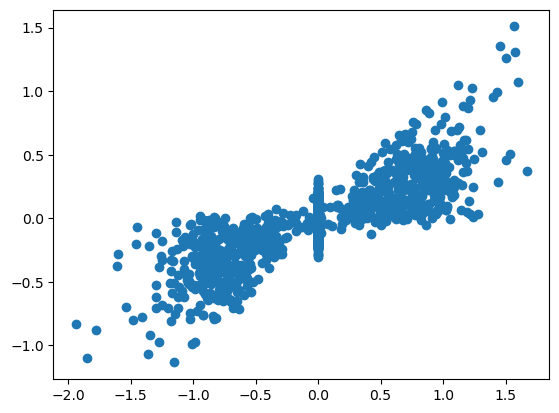

In [19]:
plt.scatter(gt_lfcs, seurat_lfcs)

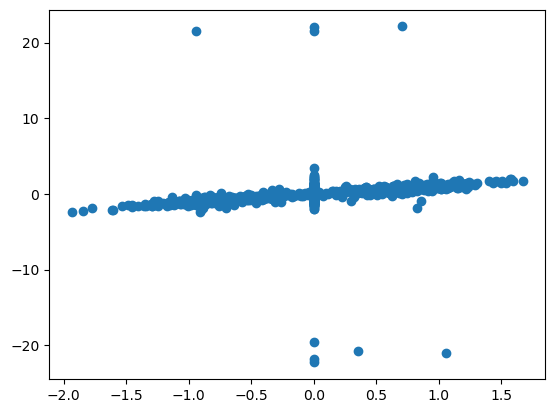

In [20]:
plt.scatter(gt_lfcs, scanpy_lfcs)

/tmp/ipykernel_142056/442298140.py:3: RuntimeWarning: divide by zero encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/tmp/ipykernel_142056/442298140.py:3: RuntimeWarning: invalid value encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/tmp/ipykernel_142056/442298140.py:3: RuntimeWarning: divide by zero encountered in log2
  unb_lfcs = np.log2(unb_x_est/unb_y_est)


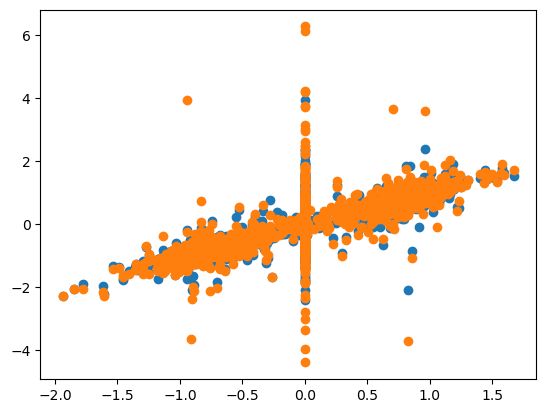

In [21]:
unb_y_est = np.mean(Y, 0)
unb_x_est = np.mean(X, 0)
unb_lfcs = np.log2(unb_x_est/unb_y_est)
plt.scatter(gt_lfcs, unb_lfcs)
plt.scatter(gt_lfcs, ziln_lfcs)
plt.show()